# MNAD Show reconstruction

## Libraries import TODO: remove unused

In [37]:
import argparse
import os
import torch
import torch.utils.data as data
import torchvision.transforms as T
import torch.nn as nn

from data.CustomDataset import CustomImageDataset
from evaluation_utils import *

## Constants

In [38]:
DATASET_DIR_SUFFIX = 'images'

## Parameters TODO: remove unused

In [39]:
args_dict = {
  "gpus": "1",                            # gpus (set 1 or None)
  "batch_size": 1,                        # batch size for testing
  "h": 256,                               # height of input images
  "w": 256,                               # width of input images
  "c": 3,                                 # channel of input images
  "method": "recon",                      # The target task for anoamly detection  (pred or recon)
  "t_length": 1,                          # length of the frame sequences
  "fdim": 512,                            # channel dimension of the features
  "mdim": 512,                            # channel dimension of the memory items
  "msize": 10,                            # number of the memory items
  "alpha": 0.7,                           # weight for the anomality score
  "th": 0.015,                            # threshold for test updating
  "num_workers": 1,                       # number of workers for the test loader
  "dataset_type": "clean_road",           # type of dataset: clean_road
  "dataset_path": "./dataset",            # directory of data
  "label_path": "./dataset",              # directory of labels
  "label_file": "metadata.csv",           # name of the label file
  "model_path": "model/trained",          # directory of model
  "model_file": "model.pth",              # name of the model file
  "m_items_path": "model/trained",        # directory of memory items
  "m_items_file": "keys.pt"               # name of the memory items file
}

args = argparse.Namespace(**args_dict)

## GPU Configurations

In [40]:
print(torch.cuda.is_available())
if args.gpus is not None and torch.cuda.is_available():
  print(torch.cuda.is_available())

  print(torch.cuda.device_count())

  print(torch.cuda.current_device())

  print(torch.cuda.device(0))

  print(torch.cuda.get_device_name(0))

True
True
1
0
Quadro T2000 with Max-Q Design


In [41]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
if args.gpus is None:
    gpus = "0"
    os.environ["CUDA_VISIBLE_DEVICES"]= gpus
else:
    gpus = ""
    for i in range(len(args.gpus)):
        gpus = gpus + args.gpus[i] + ","
    os.environ["CUDA_VISIBLE_DEVICES"]= gpus[:-1]

#torch.backends.cudnn.enabled = True # make sure to use cudnn for computational performance

## Data loading

In [42]:
images_folder = os.path.join(args.dataset_path, args.dataset_type, DATASET_DIR_SUFFIX)
images_label_file = os.path.join(args.label_path, args.dataset_type, args.label_file)

#transform = T.Resize((args.h,args.w))
transform = T.Compose([T.ToTensor(),])

# Loading dataset
images_dataset = CustomImageDataset(images_label_file, images_folder, transform = transform)
dataset_size = len(images_dataset)

images_batch = data.DataLoader(images_dataset, batch_size = args.batch_size,
                              shuffle=True, num_workers=args.num_workers, drop_last=False)
batch_size = len(images_batch)

## Model loading

In [43]:
# Loading the trained model
model_file = os.path.join(args.model_path, args.dataset_type, args.model_file)
m_items_file = os.path.join(args.m_items_path, args.dataset_type, args.m_items_file)
#model = torch.load(args.model_dir, map_location=torch.device('cpu'))
model = torch.load(model_file)
model.cuda()
#m_items = torch.load(args.m_items_dir, map_location=torch.device('cpu'))
m_items = torch.load(m_items_file)

## Function to preprocess network images before showing TODO: move into other file and use as lib

In [44]:
import cv2
def create_img_to_show(img_file, show_shapes=False):
    # Create img_to_show
    img_to_show = img_file
    # Permute the image from (C, H, W) to (H, W, C)
    if show_shapes: print(img_to_show.shape)
    img_to_show = img_to_show.permute(1, 2, 0)
    if show_shapes: print(img_to_show.shape)
    # Convert the image from tensor to numpy array
    img_to_show = img_to_show.numpy()
    # Adapt BGR to RGB for matplotlib
    img_to_show = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)
    return img_to_show


## Select image TODO: move in parameters list

In [45]:
img_name  = "clean_1.jpg"
input_img = images_dataset.get_img_by_name(img_name)

## Feed image to network TODO: remove useless operations
(m_items.clone())

In [46]:
# Clone the memory items
m_items_test = m_items.clone()
# Set the model to evaluation mode to prevent updating params
model.eval()
# Create img_to_forward
img_to_forward = input_img
# Insert image in GPU
if args.gpus is not None and torch.cuda.is_available():
    img_to_forward = img_to_forward.cuda()
# Add batch dimension
img_to_forward = img_to_forward.unsqueeze(0)
print(img_to_forward.shape)
# Forward pass
output, feas, updated_feas, m_items_test, softmax_score_query, softmax_score_memory, compactness_loss = model.forward(img_to_forward, m_items_test, False)

torch.Size([1, 3, 256, 256])


### Forward post processing

In [47]:
# Remove batch dimension
output = output.squeeze(0)
# Insert image in CPU
if args.gpus is not None and torch.cuda.is_available():
    output = output.cpu()
# Detach the output (remove it from the computational graph)
output = output.detach()
# Show the output
#output

# 

### Show both images to compare

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9841724..0.9916299].


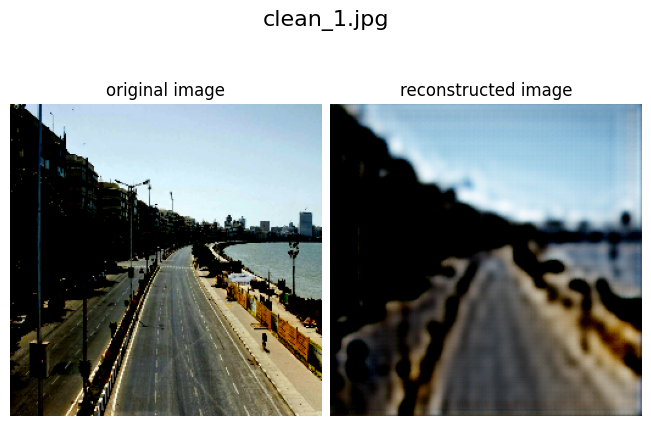

In [48]:
import matplotlib.pyplot as plt

original_img = create_img_to_show(input_img)
reconstructed_img = create_img_to_show(output)

fig, axs = plt.subplots(1, 2, constrained_layout=True)
axs[0].imshow(original_img)
axs[0].set_title('original image')
axs[0].axis('off')

fig.suptitle(img_name, fontsize=16)

axs[1].imshow(reconstructed_img)
axs[1].set_title('reconstructed image')
axs[1].axis('off')

plt.show()